In [1]:
#| default_exp models.nhits

In [10]:
#| hide
%load_ext autoreload
%autoreload 2

# NHITS

Long-horizon forecasting is challenging because of the *volatility* of the predictions and the *computational complexity*. To solve this problem we created the Neural Hierarchical Interpolation for Time Series (NHITS). `NHITS` builds upon `NBEATS` and specializes its partial outputs in the different frequencies of the time series through hierarchical interpolation and multi-rate input
processing. On the long-horizon forecasting task `NHITS` improved accuracy by 25% on AAAI's best paper award the `Informer`, while being 50x faster.

The model is composed of several MLPs with ReLU non-linearities. Blocks are connected via doubly residual stacking principle with the backcast $\mathbf{\tilde{y}}_{t-L:t,l}$ and forecast $\mathbf{\hat{y}}_{t+1:t+H,l}$ outputs of the l-th block. Multi-rate input pooling, hierarchical interpolation and backcast residual connections together induce the specialization of the additive predictions in different signal bands, reducing memory footprint and computational time, thus improving the architecture parsimony and accuracy.

**References**<br>
-[Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting".](https://arxiv.org/abs/1905.10437)<br>
-[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2023). "NHITS: Neural Hierarchical Interpolation for Time Series Forecasting". Accepted at the Thirty-Seventh AAAI Conference on Artificial Intelligence.](https://arxiv.org/abs/2201.12886)<br>
-[Zhou, H.; Zhang, S.; Peng, J.; Zhang, S.; Li, J.; Xiong, H.; and Zhang, W. (2020). "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting". Association for the Advancement of Artificial Intelligence Conference 2021 (AAAI 2021).](https://arxiv.org/abs/2012.07436)

![Figure 1. Neural Hierarchical Interpolation for Time Series (NHITS).](imgs_models/nhits.png)

In [11]:
#| hide
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [12]:
#| export
from typing import Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [13]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

In [14]:
#| hide
import logging
import warnings

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

#plt.rcParams["axes.grid"]=True
plt.rcParams['font.family'] = 'serif'
#plt.rcParams["figure.figsize"] = (4,2)

In [15]:
#| export
class _IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int, 
                 interpolation_mode: str, out_features: int=1):
        super().__init__()
        assert (interpolation_mode in ['linear','nearest']) or ('cubic' in interpolation_mode)
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
        self.interpolation_mode = interpolation_mode
        self.out_features = out_features
 
    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        backcast = theta[:, :self.backcast_size]
        knots = theta[:, self.backcast_size:]

        # Interpolation is performed on default dim=-1 := H
        knots = knots.reshape(len(knots), self.out_features, -1)
        if self.interpolation_mode in ['nearest', 'linear']:
            #knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            #forecast = forecast[:,0,:]
        elif 'cubic' in self.interpolation_mode:
            if self.out_features>1:
                raise Exception('Cubic interpolation not available with multiple outputs.')
            batch_size = len(backcast)
            knots = knots[:,None,:,:]
            forecast = torch.zeros((len(knots), self.forecast_size)).to(knots.device)
            n_batches = int(np.ceil(len(knots)/batch_size))
            for i in range(n_batches):
                forecast_i = F.interpolate(knots[i*batch_size:(i+1)*batch_size], 
                                           size=self.forecast_size, mode='bicubic')
                forecast[i*batch_size:(i+1)*batch_size] += forecast_i[:,0,0,:] # [B,None,H,H] -> [B,H]
            forecast = forecast[:,None,:] # [B,H] -> [B,None,H]

        # [B,Q,H] -> [B,H,Q]
        forecast = forecast.permute(0, 2, 1)
        return backcast, forecast

In [16]:
#| exporti
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

POOLING = ['MaxPool1d',
           'AvgPool1d']

class NHITSBlock(nn.Module):
    """
    NHITS block which takes a basis function as an argument.
    """
    def __init__(self, 
                 input_size: int,
                 h: int,
                 n_theta: int,
                 mlp_units: list,
                 basis: nn.Module,
                 futr_input_size: int,
                 hist_input_size: int,
                 stat_input_size: int,
                 n_pool_kernel_size: int,
                 pooling_mode: str,
                 dropout_prob: float,
                 activation: str):
        super().__init__()

        pooled_hist_size = int(np.ceil(input_size/n_pool_kernel_size))
        pooled_futr_size = int(np.ceil((input_size+h)/n_pool_kernel_size))

        input_size = pooled_hist_size + \
                     hist_input_size * pooled_hist_size + \
                     futr_input_size * pooled_futr_size + stat_input_size

        self.dropout_prob = dropout_prob
        self.futr_input_size = futr_input_size
        self.hist_input_size = hist_input_size
        self.stat_input_size = stat_input_size
        
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        assert pooling_mode in POOLING, f'{pooling_mode} is not in {POOLING}'

        activ = getattr(nn, activation)()

        self.pooling_layer = getattr(nn, pooling_mode)(kernel_size=n_pool_kernel_size,
                                                       stride=n_pool_kernel_size, ceil_mode=True)

        # Block MLPs
        hidden_layers = [nn.Linear(in_features=input_size, 
                                   out_features=mlp_units[0][0])]
        for layer in mlp_units:
            hidden_layers.append(nn.Linear(in_features=layer[0], 
                                           out_features=layer[1]))
            hidden_layers.append(activ)

            if self.dropout_prob>0:
                #raise NotImplementedError('dropout')
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=mlp_units[-1][1], out_features=n_theta)]
        layers = hidden_layers + output_layer
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: torch.Tensor, futr_exog: torch.Tensor,
                hist_exog: torch.Tensor, stat_exog: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        # Pooling
        # Pool1d needs 3D input, (B,C,L), adding C dimension
        insample_y = insample_y.unsqueeze(1)
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        # Flatten MLP inputs [B, L+H, C] -> [B, (L+H)*C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | F_{t-L},..., F_{t+H} | S ]
        batch_size = len(insample_y)
        if self.hist_input_size > 0:
            hist_exog = hist_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            hist_exog = self.pooling_layer(hist_exog)
            hist_exog = hist_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, hist_exog.reshape(batch_size,-1) ), dim=1)

        if self.futr_input_size > 0:
            futr_exog = futr_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            futr_exog = self.pooling_layer(futr_exog)
            futr_exog = futr_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, futr_exog.reshape(batch_size,-1) ), dim=1)

        if self.stat_input_size > 0:
            insample_y = torch.cat(( insample_y, stat_exog.reshape(batch_size,-1) ), dim=1)

        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta)
        return backcast, forecast

In [17]:
#| export
class NHITS(BaseWindows):
    """ NHITS

    The Neural Hierarchical Interpolation for Time Series (NHITS), is an MLP-based deep
    neural architecture with backward and forward residual links. NHITS tackles volatility and
    memory complexity challenges, by locally specializing its sequential predictions into
    the signals frequencies with hierarchical interpolation and pooling.

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
    `stack_types`: List[str], stacks list in the form N * ['identity'], to be deprecated in favor of `n_stacks`. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
    `mlp_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
    `n_freq_downsample`: List[int], list with the stack's coefficients (inverse expressivity ratios). Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `interpolation_mode`: str='linear', interpolation basis from ['linear', 'nearest', 'cubic'].<br>
    `n_pool_kernel_size`: List[int], list with the size of the windows to take a max/avg over. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
    `pooling_mode`: str, input pooling module from ['MaxPool1d', 'AvgPool1d'].<br>
    `dropout_prob_theta`: float, Float between (0, 1). Dropout for NHITS basis.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References:**<br>
    -[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, 
    Max Mergenthaler-Canseco, Artur Dubrawski (2023). "NHITS: Neural Hierarchical Interpolation for Time Series Forecasting".
    Accepted at the Thirty-Seventh AAAI Conference on Artificial Intelligence.](https://arxiv.org/abs/2201.12886)
    """
    # Class attributes
    SAMPLING_TYPE = 'windows'

    def __init__(self, 
                 h,
                 input_size,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 stack_types: list = ['identity', 'identity', 'identity'],
                 n_blocks: list = [1, 1, 1],
                 mlp_units: list = 3 * [[512, 512]],
                 n_pool_kernel_size: list = [2, 2, 1],
                 n_freq_downsample: list = [4, 2, 1],
                 pooling_mode: str = 'MaxPool1d',
                 interpolation_mode: str = 'linear',
                 dropout_prob_theta = 0.,
                 activation = 'ReLU',
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = 3,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size: int = 1024,
                 inference_windows_batch_size: int = -1,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader = 0,
                 drop_last_loader = False,
                 **trainer_kwargs):

        # Inherit BaseWindows class
        super(NHITS, self).__init__(h=h,
                                    input_size=input_size,
                                    futr_exog_list=futr_exog_list,
                                    hist_exog_list=hist_exog_list,
                                    stat_exog_list=stat_exog_list,
                                    exclude_insample_y = exclude_insample_y,
                                    loss=loss,
                                    valid_loss=valid_loss,
                                    max_steps=max_steps,
                                    learning_rate=learning_rate,
                                    num_lr_decays=num_lr_decays,
                                    early_stop_patience_steps=early_stop_patience_steps,
                                    val_check_steps=val_check_steps,
                                    batch_size=batch_size,
                                    windows_batch_size=windows_batch_size,
                                    valid_batch_size=valid_batch_size,
                                    inference_windows_batch_size=inference_windows_batch_size,
                                    start_padding_enabled=start_padding_enabled,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    random_seed=random_seed,
                                    **trainer_kwargs)

        # Architecture
        self.futr_input_size = len(self.futr_exog_list)
        self.hist_input_size = len(self.hist_exog_list)
        self.stat_input_size = len(self.stat_exog_list)

        blocks = self.create_stack(h=h,
                                   input_size=input_size,
                                   stack_types=stack_types,
                                   futr_input_size=self.futr_input_size,
                                   hist_input_size=self.hist_input_size,
                                   stat_input_size=self.stat_input_size,                                   
                                   n_blocks=n_blocks,
                                   mlp_units=mlp_units,
                                   n_pool_kernel_size=n_pool_kernel_size,
                                   n_freq_downsample=n_freq_downsample,
                                   pooling_mode=pooling_mode,
                                   interpolation_mode=interpolation_mode,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation)
        self.blocks = torch.nn.ModuleList(blocks)

    def create_stack(self,
                     h, 
                     input_size,    
                     stack_types, 
                     n_blocks,
                     mlp_units,
                     n_pool_kernel_size,
                     n_freq_downsample,
                     pooling_mode,
                     interpolation_mode,
                     dropout_prob_theta, 
                     activation,
                     futr_input_size, hist_input_size, stat_input_size):                     

        block_list = []
        for i in range(len(stack_types)):
            for block_id in range(n_blocks[i]):

                assert stack_types[i] == 'identity', f'Block type {stack_types[i]} not found!'

                n_theta = (input_size + self.loss.outputsize_multiplier*max(h//n_freq_downsample[i], 1) )
                basis = _IdentityBasis(backcast_size=input_size, forecast_size=h,
                                       out_features=self.loss.outputsize_multiplier,
                                       interpolation_mode=interpolation_mode)

                nbeats_block = NHITSBlock(h=h,
                                          input_size=input_size,
                                          futr_input_size=futr_input_size,
                                          hist_input_size=hist_input_size,
                                          stat_input_size=stat_input_size,                                          
                                          n_theta=n_theta,
                                          mlp_units=mlp_units,
                                          n_pool_kernel_size=n_pool_kernel_size[i],
                                          pooling_mode=pooling_mode,
                                          basis=basis,
                                          dropout_prob=dropout_prob_theta,
                                          activation=activation)

                # Select type of evaluation and apply it to all layers of block
                block_list.append(nbeats_block)
                
        return block_list

    def forward(self, windows_batch):
        
        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        insample_mask = windows_batch['insample_mask']
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']
        
        # insample
        residuals = insample_y.flip(dims=(-1,)) #backcast init
        insample_mask = insample_mask.flip(dims=(-1,))
        
        forecast = insample_y[:, -1:, None] # Level with Naive1
        block_forecasts = [ forecast.repeat(1, self.h, 1) ]
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, futr_exog=futr_exog,
                                             hist_exog=hist_exog, stat_exog=stat_exog)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast
            
            if self.decompose_forecast:
                block_forecasts.append(block_forecast)
        
        # Adapting output's domain
        forecast = self.loss.domain_map(forecast)

        if self.decompose_forecast:
            # (n_batch, n_blocks, h, output_size)
            block_forecasts = torch.stack(block_forecasts)
            block_forecasts = block_forecasts.permute(1,0,2,3)
            block_forecasts = block_forecasts.squeeze(-1) # univariate output
            return block_forecasts
        else:
            return forecast

In [8]:
show_doc(NHITS)

---

### NHITS

>      NHITS (h, input_size, futr_exog_list=None, hist_exog_list=None,
>             stat_exog_list=None, exclude_insample_y=False,
>             stack_types:list=['identity', 'identity', 'identity'],
>             n_blocks:list=[1, 1, 1], mlp_units:list=[[512, 512], [512, 512],
>             [512, 512]], n_pool_kernel_size:list=[2, 2, 1],
>             n_freq_downsample:list=[4, 2, 1], pooling_mode:str='MaxPool1d',
>             interpolation_mode:str='linear', dropout_prob_theta=0.0,
>             activation='ReLU', loss=MAE(), valid_loss=None,
>             max_steps:int=1000, learning_rate:float=0.001,
>             num_lr_decays:int=3, early_stop_patience_steps:int=-1,
>             val_check_steps:int=100, batch_size:int=32,
>             valid_batch_size:Optional[int]=None, windows_batch_size:int=1024,
>             inference_windows_batch_size:int=-1, start_padding_enabled=False,
>             step_size:int=1, scaler_type:str='identity', random_seed:int=1,
>             num_workers_loader=0, drop_last_loader=False, **trainer_kwargs)

NHITS

The Neural Hierarchical Interpolation for Time Series (NHITS), is an MLP-based deep
neural architecture with backward and forward residual links. NHITS tackles volatility and
memory complexity challenges, by locally specializing its sequential predictions into
the signals frequencies with hierarchical interpolation and pooling.

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
`activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
`stack_types`: List[str], stacks list in the form N * ['identity'], to be deprecated in favor of `n_stacks`. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
`n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
`mlp_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
`n_freq_downsample`: List[int], list with the stack's coefficients (inverse expressivity ratios). Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
`interpolation_mode`: str='linear', interpolation basis from ['linear', 'nearest', 'cubic'].<br>
`n_pool_kernel_size`: List[int], list with the size of the windows to take a max/avg over. Note that len(stack_types)=len(n_freq_downsample)=len(n_pool_kernel_size).<br>
`pooling_mode`: str, input pooling module from ['MaxPool1d', 'AvgPool1d'].<br>
`dropout_prob_theta`: float, Float between (0, 1). Dropout for NHITS basis.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
`windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References:**<br>
-[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, 
Max Mergenthaler-Canseco, Artur Dubrawski (2023). "NHITS: Neural Hierarchical Interpolation for Time Series Forecasting".
Accepted at the Thirty-Seventh AAAI Conference on Artificial Intelligence.](https://arxiv.org/abs/2201.12886)

In [11]:
show_doc(NHITS.fit, name='NHITS.fit')

---

### NHITS.fit

>      NHITS.fit (dataset, val_size=0, test_size=0, random_seed=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [12]:
show_doc(NHITS.predict, name='NHITS.predict')

---

### NHITS.predict

>      NHITS.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                     **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

In [13]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

Seed set to 1
2023-11-02 17:57:13.906713: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 17:57:14.034658: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 17:57:14.550773: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 17:57:14.550840: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 17:57:14.554706: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Atte

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

<Axes: xlabel='ds'>

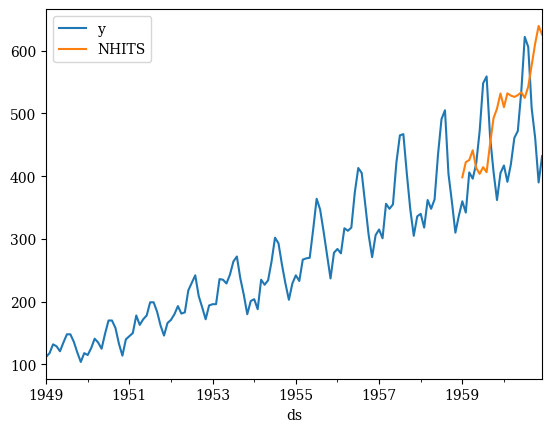

In [14]:
#| hide
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl

from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

Y_train_df = Y_df[Y_df.ds<Y_df['ds'].values[-24]] # 132 train
Y_test_df = Y_df[Y_df.ds>=Y_df['ds'].values[-24]] # 12 test

dataset, *_ = TimeSeriesDataset.from_df(df = Y_train_df)
model = NHITS(h=24,
              input_size=24*2,
              max_steps=1,
              windows_batch_size=None, 
              n_freq_downsample=[12,4,1], 
              pooling_mode='MaxPool1d')
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)
Y_test_df['NHITS'] = y_hat

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

Predicting: |                                                                                     | 0/? [00:00…

Text(0.5, 0, 'Prediction τ ∈ {t+1,..., t+H}')

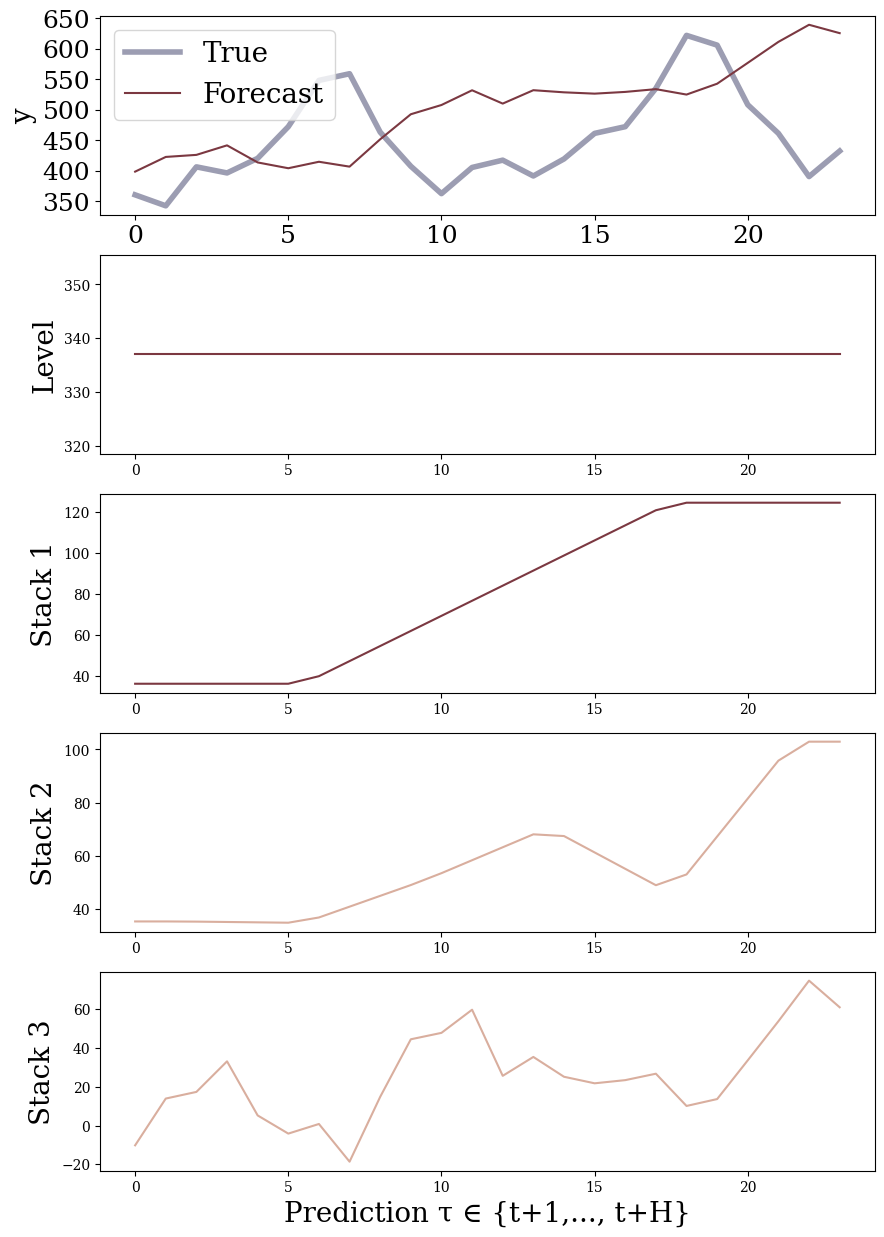

In [15]:
#| hide
# qualitative decomposition evaluation
y_hat = model.decompose(dataset=dataset)

fig, ax = plt.subplots(5, 1, figsize=(10, 15))

ax[0].plot(Y_test_df['y'].values, label='True', color="#9C9DB2", linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend(prop={'size': 20})
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(18)
ax[0].set_ylabel('y', fontsize=20)

ax[1].plot(y_hat[0,0], label='level', color="#7B3841")
ax[1].set_ylabel('Level', fontsize=20)

ax[2].plot(y_hat[0,1], label='stack1', color="#7B3841")
ax[2].set_ylabel('Stack 1', fontsize=20)

ax[3].plot(y_hat[0,2], label='stack2', color="#D9AE9E")
ax[3].set_ylabel('Stack 2', fontsize=20)

ax[4].plot(y_hat[0,3], label='stack3', color="#D9AE9E")
ax[4].set_ylabel('Stack 3', fontsize=20)

ax[4].set_xlabel('Prediction \u03C4 \u2208 {t+1,..., t+H}', fontsize=20)

## Usage Example

Seed set to 1


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

[]

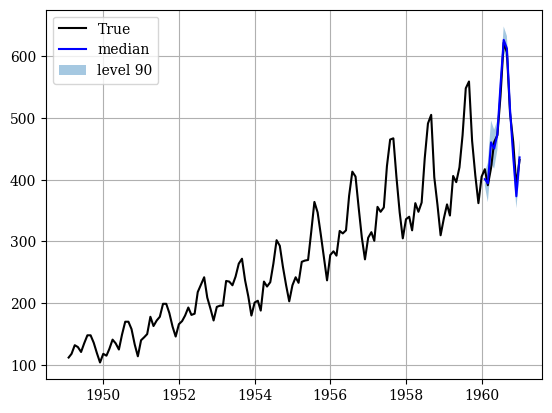

In [16]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, PMM, GMM, NBMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic


Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NHITS(h=12,
              input_size=24,
              loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
              #loss=DistributionLoss(distribution='Normal', level=[80, 90], return_params=True),
              #loss=DistributionLoss(distribution='Poisson', level=[80, 90], return_params=True),
              #loss=DistributionLoss(distribution='Tweedie', level=[80, 90], rho=1.5),
              #loss=DistributionLoss(distribution='NegativeBinomial', level=[80, 90], return_params=True),
              #loss=NBMM(n_components=2, level=[80,90]),
              #loss=GMM(n_components=2, level=[80,90]),
              #loss=PMM(n_components=1, level=[80,90]),
              stat_exog_list=['airline1'],
              futr_exog_list=['trend'],
              n_freq_downsample=[2, 1, 1],
              scaler_type='robust',
              max_steps=200,
              early_stop_patience_steps=2,
              inference_windows_batch_size=1,
              val_check_steps=10,
              learning_rate=1e-3)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NHITS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['NHITS-lo-90'][-12:].values, 
                 y2=plot_df['NHITS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

In [17]:
from neuralforecast.losses.numpy import mae, mse

y_true = Y_test_df.y.values
y_hat = Y_hat_df['NHITS-median'].values


print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))

MAE:  12.984341939290365
MSE:  284.7534357710586


Seed set to 1


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

[]

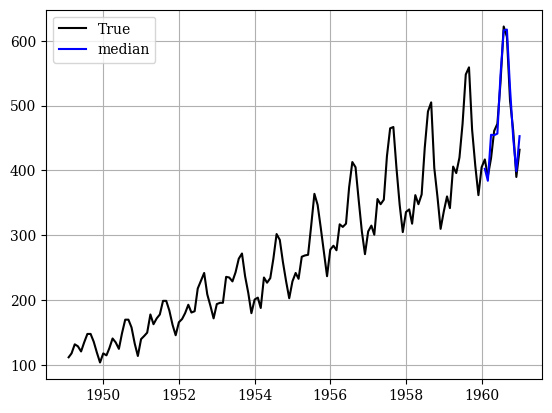

In [18]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import DistributionLoss, HuberLoss, MAE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

#AirPassengersPanel['y'] = 1 * (AirPassengersPanel['trend'] % 12) < 2
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NHITS(h=12,
              input_size=24,
              #loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
              loss=HuberLoss(delta=0.5),
              valid_loss=MAE(),
              stat_exog_list=['airline1'],
              scaler_type='robust',
              max_steps=200,
              early_stop_patience_steps=2,
              val_check_steps=10,
              learning_rate=1e-3)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='median')
# plt.plot(plot_df['ds'], plot_df['NHITS-median'], c='blue', label='median')
# plt.fill_between(x=plot_df['ds'][-12:], 
#                  y1=plot_df['NHITS-lo-90'][-12:].values, 
#                  y2=plot_df['NHITS-hi-90'][-12:].values,
#                  alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

In [19]:
from neuralforecast.losses.numpy import mae, mse

y_true = Y_test_df.y.values
y_hat = Y_hat_df['NHITS'].values


print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))

MAE:  14.19897206624349
MSE:  270.2152161945899


# AutoNHITS Implementation

### Exchange rate 

In [1]:
from ray import tune
import pandas as pd
from neuralforecast.core import NeuralForecast 
from neuralforecast.auto import AutoNHITS

In [2]:
Y_df = pd.read_csv("raw_data/df_Exchange.csv")

Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 20% of the DataSet
n_time = len(Y_df.ds.unique())
val_size = int(.1 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,0,1990-01-01,0.606785
1,0,1990-01-02,0.570900
7588,1,1990-01-01,-0.361671
7589,1,1990-01-02,-0.367639
15176,2,1990-01-01,0.735367
15177,2,1990-01-02,0.729629
22764,3,1990-01-01,-1.164373
22765,3,1990-01-02,-1.170907
30352,4,1990-01-01,2.851890
30353,4,1990-01-02,2.851890


In [3]:
horizon = 96 # 24hrs = 4 * 15 min.

# Use your own config or AutoNHITS.default_config
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([100]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([8]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([10]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
    }

In [4]:
models = [AutoNHITS(h=horizon,
                    config=nhits_config,
                    num_samples=5)]

In [5]:
nf = NeuralForecast(
    models=models,
    freq='D')

Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

(_train_tune pid=6155) Seed set to 6
(_train_tune pid=6155) 2023-11-04 14:21:28.456271: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(_train_tune pid=6155) 2023-11-04 14:21:28.458635: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(_train_tune pid=6155) 2023-11-04 14:21:28.494230: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=6155) 2023-11-04 14:21:28.494266: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=6

Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s, v_num=0, train_loss_step=0.229, train_loss_epoch=0.207]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s, v_num=0, train_loss_step=0.205, train_loss_epoch=0.218, valid_loss=0.264]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s, v_num=0, train_loss_step=0.222, train_loss_epoch=0.222, valid_loss=0.298]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s, v_num=0, train_loss_step=0.193, train_loss_epoch=0.208, valid_loss=0.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?

(_train_tune pid=6155) Seed set to 7


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s, v_num=0, train_loss_step=0.219, train_loss_epoch=0.205]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s, v_num=0, train_loss_step=0.210, train_loss_epoch=0.216, valid_loss=0.246]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s, v_num=0, train_loss_step=0.212, train_loss_epoch=0.201, valid_loss=0.291]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.205, valid_loss=0.291]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?

(_train_tune pid=6155) Seed set to 9


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s, v_num=0, train_loss_step=0.216, train_loss_epoch=0.196]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s, v_num=0, train_loss_step=0.214, train_loss_epoch=0.208, valid_loss=0.283]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s, v_num=0, train_loss_step=0.222, train_loss_epoch=0.205, valid_loss=0.344]
(_train_tune pid=6155) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=6155) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s, v_num=0, train_loss_step=0.186, train_loss_epoch=0.179, valid_loss=0.272]
Validation: |          | 0/? [00:00<?, ?it/s]
Valida

(_train_tune pid=6155) Seed set to 3


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s, v_num=0, train_loss_step=0.219, train_loss_epoch=0.227]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  9.78it/s, v_num=0, train_loss_step=0.210, train_loss_epoch=0.226, valid_loss=0.272]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s, v_num=0, train_loss_step=0.209, train_loss_epoch=0.185, valid_loss=0.271]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s, v_num=0, train_loss_step=0.217, train_loss_epoch=0.217, valid_loss=0.274]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?

(_train_tune pid=6155) Seed set to 6


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s, v_num=0, train_loss_step=0.229, train_loss_epoch=0.207]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s, v_num=0, train_loss_step=0.204, train_loss_epoch=0.218, valid_loss=0.264]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s, v_num=0, train_loss_step=0.219, train_loss_epoch=0.219, valid_loss=0.309]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s, v_num=0, train_loss_step=0.194, train_loss_epoch=0.208, valid_loss=0.334]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?

Seed set to 7


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s, v_num=0, train_loss_step=0.189, train_loss_epoch=0.207, valid_loss=0.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6155) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s, v_num=0, train_loss_step=0.189, train_loss_epoch=0.189, valid_loss=0.355]


2023-11-04 14:22:36.024653: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-04 14:22:36.026315: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-04 14:22:36.050932: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 14:22:36.050955: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 14:22:36.050972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

In [5]:
nf = NeuralForecast(
    models=models,
    freq='D')

Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

(_train_tune pid=7588) Seed set to 8
(_train_tune pid=7588) 2023-11-02 03:18:33.048410: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(_train_tune pid=7588) 2023-11-02 03:18:33.081815: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(_train_tune pid=7588) 2023-11-02 03:18:33.234842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=7588) 2023-11-02 03:18:33.235007: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune pid=7

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.190]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=7588) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7588) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.199, valid_loss=0.339]


(_train_tune pid=7588) Seed set to 3


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.203]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7588) 
Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.61it/s, v_num=0, train_loss_step=0.199, train_loss_epoch=0.199, valid_loss=0.339]


(_train_tune pid=7588) Seed set to 6


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=7588) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7588) 
Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.73it/s, v_num=0, train_loss_step=0.181, train_loss_epoch=0.181, valid_loss=0.317]


(_train_tune pid=7588) Seed set to 4


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s, v_num=0, train_loss_step=0.212, train_loss_epoch=0.215]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=7588) 
Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.89it/s, v_num=0, train_loss_step=0.212, train_loss_epoch=0.212, valid_loss=0.331]


(_train_tune pid=7588) Seed set to 3


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s, v_num=0, train_loss_step=0.194, train_loss_epoch=0.195]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


Seed set to 6


(_train_tune pid=7588) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, v_num=0, train_loss_step=0.194, train_loss_epoch=0.194, valid_loss=0.340]


2023-11-02 03:22:11.024096: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 03:22:11.040501: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 03:22:11.252872: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 03:22:11.252943: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 03:22:11.252993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

In [8]:
Y_hat_df.head()

,unique_id,ds,cutoff,AutoNHITS,y
0,0,2006-08-16,2006-08-15,2.945293,2.948076
1,0,2006-08-17,2006-08-15,2.936055,3.049320
2,0,2006-08-18,2006-08-15,2.945046,3.064168
3,0,2006-08-19,2006-08-15,2.964904,3.005783
4,0,2006-08-20,2006-08-15,2.908318,3.010031


In [7]:
Y_hat_df.to_csv('results/Exchange_rate/AutoNHITS.csv')

In [6]:
from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(Y_hat_df['y'], Y_hat_df['AutoNHITS']))
print('MSE: ', mse(Y_hat_df['y'], Y_hat_df['AutoNHITS']))

MAE:  0.2089021863763513
MSE:  0.08673494391505497


### Ettm2

In [26]:
import pandas as pd
from neuralforecast.core import NeuralForecast 

Y_df = pd.read_csv("raw_data/df_Ettm2.csv")

Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 20% of the DataSet
n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,HUFL,2016-07-01 00:00:00,-0.041413
1,HUFL,2016-07-01 00:15:00,-0.185467
57600,HULL,2016-07-01 00:00:00,0.040104
57601,HULL,2016-07-01 00:15:00,-0.214450
115200,LUFL,2016-07-01 00:00:00,0.695804
115201,LUFL,2016-07-01 00:15:00,0.434685
172800,LULL,2016-07-01 00:00:00,0.434430
172801,LULL,2016-07-01 00:15:00,0.428168
230400,MUFL,2016-07-01 00:00:00,-0.599211
230401,MUFL,2016-07-01 00:15:00,-0.658068


In [30]:
horizon = 96 # 24hrs = 4 * 15 min.

# Use your own config or AutoNHITS.default_config
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([100]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
    }

models = [AutoNHITS(h=horizon,
                    config=nhits_config, 
                    num_samples=5)]

%%capture
nf = NeuralForecast(
    models=models,
    freq='15min')

Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

Seed set to 1


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Predicting: |                                                                                     | 0/? [00:00…

In [1]:
from neuralforecast.losses.numpy import mae, mse

print('MAE: ', 0.26096806135482414)
print('MSE: ', 0.18279484416711375)

MAE:  0.26096806135482414
MSE:  0.18279484416711375


In [ ]:
Y_hat_df.to_csv('results/Ettm2/NHITS.csv')

### Weather

In [9]:
import pandas as pd
from neuralforecast.core import NeuralForecast 

Y_df = pd.read_csv("raw_data/df_Weather.csv")

Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 20% of the DataSet
n_time = len(Y_df.ds.unique())
val_size = int(.1 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,H2OC (mmol/mol),2020-01-01 00:10:00,-0.999107
1,H2OC (mmol/mol),2020-01-01 00:20:00,-1.008072
52695,OT,2020-01-01 00:10:00,0.044395
52696,OT,2020-01-01 00:20:00,0.044134
105390,PAR (�mol/m�/s),2020-01-01 00:10:00,-0.679493
105391,PAR (�mol/m�/s),2020-01-01 00:20:00,-0.679493
158085,SWDR (W/m�),2020-01-01 00:10:00,-0.672767
158086,SWDR (W/m�),2020-01-01 00:20:00,-0.672767
210780,T (degC),2020-01-01 00:10:00,-1.459980
210781,T (degC),2020-01-01 00:20:00,-1.454798


In [3]:
horizon = 96 # 24hrs = 4 * 15 min.

# Use your own config or AutoNHITS.default_config
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([100]),                                         # Number of SGD steps
       "input_size": tune.choice([horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([21]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([10]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
    }

models = [AutoNHITS(h=horizon,
                    config=nhits_config,
                    num_samples=5)]

nf = NeuralForecast(
    models=models,
    freq='10min')

Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

(_train_tune pid=14309) Seed set to 7
(_train_tune pid=14309) 2023-11-02 17:50:05.859747: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(_train_tune pid=14309) 2023-11-02 17:50:05.898412: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(_train_tune pid=14309) 2023-11-02 17:50:05.952885: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=14309) 2023-11-02 17:50:05.952943: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(_train_tune 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.93it/s, v_num=0, train_loss_step=0.351, train_loss_epoch=0.409]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14309) 
Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, v_num=0, train_loss_step=0.366, train_loss_epoch=0.348, valid_loss=0.359]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14309) 
Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=0, train_loss_step=0.366, train_loss_epoch=0.356, valid_loss=0.325]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14309) 
Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, v_num=0, train_loss_step=0.346, train_loss_epoch=0.318, valid_loss=0.314]
Validation: |          | 0/? [00:00<?, ?it/s]


(_train_tune pid=14309) Seed set to 7


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s, v_num=0, train_loss_step=0.361, train_loss_epoch=0.407]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=14309) 
Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.403, train_loss_epoch=0.403, valid_loss=0.364]        


RuntimeError: Caught unexpected exception: Task was killed due to the node running low on memory.
Memory on the node (IP: 172.17.132.167, ID: 12020b96e7d4c1257179a1a072a6d23c1936d7110758424804cde666) where the task (actor ID: 3f4e94326b59d8d86eafbe9801000000, name=ImplicitFunc.__init__, pid=14309, memory used=0.90GB) was running was 7.24GB / 7.62GB (0.95008), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 2b537369b67a0787ac408025f63343000616a0a5d6290cb781ad8051) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 172.17.132.167`. To see the logs of the worker, use `ray logs worker-2b537369b67a0787ac408025f63343000616a0a5d6290cb781ad8051*out -ip 172.17.132.167. Top 10 memory users:
PID	MEM(GB)	COMMAND
13680	1.06	/usr/bin/python3 -m ipykernel_launcher -f /home/blair/.local/share/jupyter/runtime/kernel-cc0fecc7-3...
14309	0.90	ray::ImplicitFunc.train
1447	0.43	/usr/bin/python3 -m ipykernel_launcher -f /home/blair/.local/share/jupyter/runtime/kernel-795da834-6...
8455	0.23	/usr/bin/python3 -m ipykernel_launcher -f /home/blair/.local/share/jupyter/runtime/kernel-19cae6ed-0...
13795	0.23	/home/blair/.local/lib/python3.10/site-packages/ray/core/src/ray/raylet/raylet --raylet_socket_name=...
13739	0.23	/home/blair/.local/lib/python3.10/site-packages/ray/core/src/ray/gcs/gcs_server --log_dir=/tmp/ray/s...
10774	0.10	/usr/bin/python3 -m ipykernel_launcher -f /home/blair/.local/share/jupyter/runtime/kernel-aee0fec4-4...
13780	0.08	/usr/bin/python3 -u /home/blair/.local/lib/python3.10/site-packages/ray/autoscaler/_private/monitor....
13781	0.07	/usr/bin/python3 /home/blair/.local/lib/python3.10/site-packages/ray/dashboard/dashboard.py --host=1...
13796	0.06	/usr/bin/python3 -u /home/blair/.local/lib/python3.10/site-packages/ray/_private/log_monitor.py --lo...
Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. Set max_restarts and max_task_retries to enable retry when the task crashes due to OOM. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.

In [2]:
from neuralforecast.losses.numpy import mae, mse # INPUT SIZE = 96

print('MAE: ', mae(Y_hat_df['y'], Y_hat_df['AutoNHITS']))
print('MSE: ', mse(Y_hat_df['y'], Y_hat_df['AutoNHITS']))

MAE:  0.23199070626996326
MSE:  0.20198460555905476


### NHITS - NOT AUTONHITS

In [10]:
horizon = 96

models = [NHITS(h=horizon,
                input_size = 5*horizon,
                batch_size = 21,
                windows_batch_size = 256,
                max_steps = 200,
                val_check_steps=20
               )]

nf = NeuralForecast(
    models=models,
    freq='10min')

Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

Seed set to 1
2023-11-02 18:22:24.437749: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 18:22:24.469122: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 18:22:24.617762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 18:22:24.617786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 18:22:24.618739: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Atte

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:03…

Predicting: |                                                                                     | 0/? [00:00…

In [11]:
from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(Y_hat_df['y'], Y_hat_df['NHITS']))
print('MSE: ', mse(Y_hat_df['y'], Y_hat_df['NHITS']))

MAE:  0.19757447049855434
MSE:  0.16556661850686696


In [12]:
Y_hat_df.to_csv('results/Weather/NHITS.csv')

In [14]:
data = {'Informer_MSE': mse(Y_hat_df['y'], Y_hat_df['NHITS']),
        'Informer_MAE': mae(Y_hat_df['y'], Y_hat_df['NHITS'])}

df = pd.DataFrame(data, index=['Weather'])
df.to_csv('results/Weather/df_NHITS.csv')